In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


df=pd.read_csv('af_water.csv')
colname=df.columns

In [51]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

# 构建去噪自编码器模型
def create_model(input_dim,encoding_dim):
# input_dim = 9
# encoding_dim = 5
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(7, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    decoded = Dense(7, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder=Model(input_layer,encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  #binary_crossentropy
    return autoencoder,encoder

# 添加高斯噪声
def add_noise(x):
    noise_factor = 0.1
    x_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    return np.clip(x_noisy, 0., 1.)


# 配置模型并进行训练
def train_model(model,x_train,x_test,epochs=50,batch_size=128):
    model.fit(add_noise(x_train), x_train, epochs=epochs, validation_data=(x_test, x_test),batch_size=batch_size, shuffle=True)

# 提取深度特征
# encoder = Model(input_layer, encoded)
# encoded_input = Input(shape=(encoding_dim,))
# decoder_layer = autoencoder.layers[-1]
# decoder = Model(encoded_input, decoder_layer(encoded_input))


In [52]:
#划分数据集
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
df_copy=df
X=df.drop(["Potability"],axis=1)
Y=df.Potability

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7,test_size=0.3,random_state=100,shuffle=False)

scaler = MinMaxScaler()
# Scaling the numeric variables of train dataset
X_train[X_train.columns]= scaler.fit_transform(X_train[X_train.columns])
# Scaling the numeric variables of test dataset
X_test[X_test.columns]= scaler.transform(X_test[X_test.columns])


In [53]:
#创建网络
autoencoder,encoder=create_model(9,5)
train_model(autoencoder, X_train,X_test, batch_size=32, epochs=100)

Epoch 1/100
72/72 [==============================] - 2s 11ms/step - loss: 0.0195 - val_loss: 0.0187
Epoch 2/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 3/100
72/72 [==============================] - 0s 4ms/step - loss: 0.0173 - val_loss: 0.0170
Epoch 4/100
72/72 [==============================] - 0s 4ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 5/100
72/72 [==============================] - 0s 4ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 6/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 7/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 8/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0159 - val_loss: 0.0157
Epoch 9/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.0156
Epoch 10/100
72/72 [==============================] - 0s 5ms/step - loss: 0.0157 - val_loss: 0.0155
Epoch 11

In [54]:
from sklearn.metrics import r2_score
X_pred = autoencoder.predict(X_test)
r2 = r2_score(X_test, X_pred)
r2

31/31 [==============================] - 0s 1ms/step


0.20928165569165005

In [55]:
#直接进行聚类

x_encoder=encoder.predict(X_train)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

# 获取每个子模式所属的簇的标签
labels = kmeans.labels_

72/72 [==============================] - 0s 1ms/step


d:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Accuracy:  46.31 %


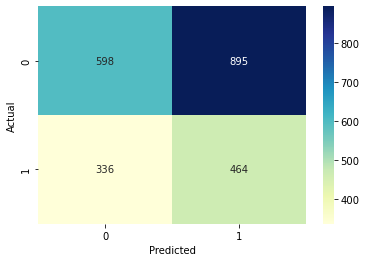

In [58]:
import seaborn as sns
from sklearn.metrics import accuracy_score
confusion_matrix = pd.crosstab(Y_train, labels, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu" ,fmt='g')
Accuracy_Decision_Tree=round((accuracy_score(Y_train, labels)*100),2)
print('Accuracy: ',Accuracy_Decision_Tree,"%")

In [ ]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
import numpy as np

# 定义VAE模型
def build_vae(original_dim, intermediate_dim, latent_dim):
    # 编码器
    inputs = Input(shape=(original_dim,))
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # 采样函数
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=0., stddev=1.)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # 重参数化层
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # 解码器
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='linear')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # 定义VAE模型
    vae = Model(inputs, x_decoded_mean)

    # 定义损失函数
    reconstruction_loss = original_dim * metrics.mean_squared_error(inputs, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    return vae

# 定义输入数据的维度和潜在空间维度
original_dim = 9
latent_dim = 3

# 构建VAE模型
vae = build_vae(original_dim, 6, latent_dim)
vae.compile(optimizer='adam')
vae.summary()

# 生成虚拟数据
x_train = np.random.rand(1000, original_dim)
vae.fit(x_train, epochs=50, batch_size=32)

# 生成虚拟数据
z_sample = np.array([[-1.5, 0.5, 1.0]])
x_decoded = vae.predict(z_sample)
print(x_decoded)


In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

# 假设你的数据集已经加载到一个numpy数组中，叫做data
data = np.random.rand(1000,9)

# 定义GAN模型的参数
latent_dim = 32 # 潜在空间的维度
batch_size = 64 # 批次大小

# 定义生成器网络，它将一个随机向量转换为一个9*1的向量
def create_generator():
    generator = keras.Sequential()
    generator.add(layers.Dense(64, input_dim=latent_dim))
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.Dense(9))
    generator.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
    return generator

# 定义判别器网络，它将一个9*1的向量判断为真实或者伪造
def create_discriminator():
    discriminator = keras.Sequential()
    discriminator.add(layers.Dense(64, input_dim=9))
    discriminator.add(layers.LeakyReLU(alpha=0.2))
    discriminator.add(layers.Dense(1, activation="sigmoid"))
    discriminator.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])
    return discriminator

# 创建生成器和判别器对象
generator = create_generator()
discriminator = create_discriminator()

# 定义GAN模型，它将生成器和判别器连接起来
def create_gan(generator, discriminator):
    gan = keras.Sequential()
    gan.add(generator)
    gan.add(discriminator)
    return gan

# 创建GAN对象，并编译它
gan = create_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy", optimizer="adam")

# 定义训练函数，它将在给定的迭代次数内训练GAN模型，并保存生成的向量到一个列表中
def train_gan(gan, data, epochs):
    # 获取生成器和判别器对象
    generator, discriminator = gan.layers
    
    # 创建一个空列表来存储生成的向量
    generated_vectors = []
    
    # 计算每个批次需要多少个样本，并创建一个索引数组来打乱数据集顺序 
    samples_per_batch = int(data.shape[0]/batch_size)
    index_array = np.arange(samples_per_batch) 
    
     # 对每个迭代周期进行循环 
    for epoch in range(epochs): 
         # 打乱索引数组 
         # np.random.shuffle(index_array) 
        
         # 对每个批次进行循环 
         for i in range(0, batch_size): 
            
             # 获取真实数据样本，并标记为1 
            #  real_vectors = data[index_array[i : i + samples_per_batch]] 
             real_vectors = data[i:i+samples_per_batch] 
             real_labels = np.ones((samples_per_batch, 1)) 
            
             # 从潜在空间中采样随机向量，并用生成器产生伪造数据样本，并标记为0 
             random_vectors = np.random.normal(size=(samples_per_batch, latent_dim)) 
             fake_vectors = generator.predict(random_vectors) 
             fake_labels = np.zeros((samples_per_batch, 1)) 
            
             # 将真实数据和伪造数据合并成一个批次，并打乱顺序 
             vectors = np.concatenate([real_vectors, fake_vectors]) 
             labels = np.concatenate([real_labels, fake_labels]) 
         indices = np.arange(batch_size) 
         np.random.shuffle(indices) 
         vectors = vectors[indices] 
         labels = labels[indices] 
            
            # 训练判别器网络，并计算损失值和准确率  
         d_loss,d_accuarcy=discriminator.train_on_batch(vectors ,labels)    
            # 从潜在空间中采样随机向量，并标记为1 
         random_vectors = np.random.normal(size=(batch_size, latent_dim)) 
         gan_labels = np.ones((batch_size, 1)) 
            
            # 训练GAN网络，并计算损失值 
         g_loss = gan.train_on_batch(random_vectors, gan_labels) 
            
            # 打印当前迭代周期和批次的损失值和准确率 
         print(f"Epoch {epoch}, Batch {i}, D Loss: {d_loss:.4f}, D Accuracy: {d_accuarcy:.4f}, G Loss: {g_loss:.4f}") 
            
        # 在每个迭代周期结束后，从潜在空间中采样一个随机向量，并用生成器产生一个伪造数据样本，并保存到列表中 
         random_vector = np.random.normal(size=(1, latent_dim)) 
         generated_vector = generator.predict(random_vector) 
         generated_vectors.append(generated_vector) 
    
    # 返回生成的向量列表 
    return generated_vectors

In [ ]:
train_gan(gan, data, 500)

In [59]:
import tensorflow as tf
from keras import layers

# 定义生成器函数
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(9, activation='tanh'))
    return model

# 定义判别器函数
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))
    return model
# 定义GAN网络的训练函数
def train_gan(generator, discriminator, dataset, epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # 初始化一个列表，用于存储每个批次的判别器损失值
        d_losses = []
        for batch in dataset.batch(batch_size):
            # 训练判别器
            real_samples = batch
            fake_samples = generator(tf.random.normal(shape=(batch_size, latent_dim)))
            X = tf.concat([real_samples, fake_samples], axis=0)
            y = tf.constant([[1.0]] * batch_size + [[0.0]] * batch_size)
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y)
            d_losses.append(d_loss)

            # 训练生成器
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            y = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y)

        # 计算判别器的平均损失值
        d_loss_mean = np.mean(d_losses)

        # 打印每一轮的损失值和生成器的输出
        print(f"Epoch {epoch+1}, D loss: {d_loss_mean:.4f}, G loss: {g_loss:.4f}")
        # print("Generated samples:")
        # print(fake_samples[:5])

In [ ]:
# 实例化生成器和判别器
generator = make_generator_model()
discriminator = make_discriminator_model()

generator.compile(loss='mse', optimizer='adam')
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# 组合生成器和判别器为一个GAN模型
gan = tf.keras.Sequential([generator, discriminator])

# 编译GAN模型
gan.compile(loss='binary_crossentropy', optimizer='adam')

# 加载样本数据
samples = np.array(X_train)# 你的样本数据，应该是一个numpy数组或者pandas数据框

# 计算需要补充的数量
n_samples = len(samples)
remainder = n_samples % batch_size
padding = batch_size - remainder if remainder > 0 else 0

# 用零进行补充
samples = np.pad(samples, ((0, padding), (0, 0)), mode='constant')
samples = samples.astype('float32') 

# 将样本数据转换成Dataset对象
dataset = tf.data.Dataset.from_tensor_slices(samples)

# 调用训练函数
train_gan(generator, discriminator, dataset, epochs=100, batch_size=32, latent_dim=9)

In [ ]:
import tensorflow as tf
from keras import layers

# 定义编码器函数
def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(32))
    model.add(layers.LeakyReLU())
    # 输出两个向量，分别表示均值和方差
    model.add(layers.Dense(18))
    return model

# 定义解码器函数
def make_decoder_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32, input_shape=(9,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    # 输出一个向量，表示重构后的数据
    model.add(layers.Dense(9, activation='sigmoid'))
    return model

# 定义采样函数
def sampling(mean_log_var):
  # 将均值和方差分开
  mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)
  # 计算标准差
  std = tf.exp(log_var * 0.5)
  # 从标准正态分布中采样噪声
  epsilon = tf.random.normal(shape=tf.shape(std))
  # 返回采样结果
  return mean + epsilon * std

# 实例化编码器和解码器
encoder = make_encoder_model()
decoder = make_decoder_model()

# 定义VAE模型类
class VAE(tf.keras.Model):
  def __init__(self):
    super(VAE, self).__init__()
  
  def call(self, inputs):
    # 编码输入数据得到均值和方差向量
    mean_log_var = encoder(inputs)
    # 对均值和方差进行采样得到潜在变量z
    z = sampling(mean_log_var)
    # 解码z得到重构后的输出数据
    outputs = decoder(z)   
    return outputs
# 实例化VAE模型对象 
vae = VAE()

# 编译VAE模型对象 
vae.compile(loss='mse', optimizer='adam')

# 加载样本数据并转换成float类型 
# 加载样本数据
samples = X_train# 你的样本数据，应该是一个numpy数组或者pandas数据框

# 计算需要补充的数量
n_samples = len(samples)
remainder = n_samples % batch_size
padding = batch_size - remainder if remainder > 0 else 0

# 用零进行补充
samples = np.pad(samples, ((0, padding), (0, 0)), mode='constant')
samples = samples.astype('float32')

# 训练VAE模型对象 
vae.fit(samples, samples, epochs=1000)


In [1]:
#vae-wgan-gp
import tensorflow as tf

# Network
latent_dim = 128
dropout = 0.2
leaky_relu_alpha = 0.2

# CNN
channels = 1
filters = 32
kernel_size = 3
strides = 2
padding = 'same'

# Loss Coefficients
kl_loss_coeff = 1
perc_loss_coeff = 1

class VAEWGANGP(tf.keras.Model):
    def __init__(self, encoder, decoder, discriminator, gp_weight=10.0):
        super(VAEWGANGP, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        self.gp_weight = gp_weight

    def compile(self, e_optimizer, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, kl_loss_fn, perc_loss_fn, rec_loss_fn):
        super(VAEWGANGP, self).compile()
        self.e_optimizer = e_optimizer
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.kl_loss_fn = kl_loss_fn
        self.perc_loss_fn = perc_loss_fn
        self.rec_loss_fn = rec_loss_fn
        
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
        self.perc_loss_metric = tf.keras.metrics.Mean(name = 'perc_loss')
        self.kl_loss_metric = tf.keras.metrics.Mean(name = 'kl_loss')
        self.rec_loss_metric = tf.keras.metrics.Mean(name = 'rec_loss')
        
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            _, pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    
    def call(self, data, training=False):
    # This method exists only because Keras expects it to be able to use data_generator()
    # your custom code when you call the model
    # or just pass, you don't need this method
    # for training
        pass

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric, self.perc_loss_metric, self.kl_loss_metric, self.rec_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        real_images = tf.cast(real_images, tf.float32)
        # ===========================================================================
        # Train Discriminator
        # For WGAN, it is advised to train this multiple times before training generator
        for _ in range(5):
            _, _, z_encoder_output = self.encoder(real_images)
            with tf.GradientTape() as tape:
                fake_images = self.decoder(z_encoder_output, training = True)
                _, logits_fake_images = self.discriminator(fake_images, training = True)
                _, logits_real_images = self.discriminator(real_images, training = True)

                d_cost = self.d_loss_fn(logits_real_images, logits_fake_images)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            
        # ===========================================================================
        # Training Encoder
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma, z_encoder_output = self.encoder(real_images, training = True)
            kl_loss = self.kl_loss_fn(z_mean, z_log_sigma) * kl_loss_coeff
            
            fake_images = self.decoder(z_encoder_output, training = True)
            fake_inter_activations, logits_fake = self.discriminator(fake_images, training = True)
            real_inter_activations, logits_real = self.discriminator(real_images, training = True)
            
            perc_loss = self.perc_loss_fn(fake_inter_activations, real_inter_activations) * perc_loss_coeff

            total_encoder_loss = kl_loss + perc_loss
            
        grads = tape.gradient(total_encoder_loss, self.encoder.trainable_weights)
        self.e_optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))
        
        # ===========================================================================
        # Train Decoder
        _, _, z_encoder_output = self.encoder(real_images)
        with tf.GradientTape() as tape:
            fake_images = self.decoder(z_encoder_output)
            fake_inter_activations, logits_fake = self.discriminator(fake_images, training = True)
            real_inter_activations, _ = self.discriminator(real_images, training = True)
            
            g_loss = self.g_loss_fn(logits_fake, 0)
            perc_loss = self.perc_loss_fn(fake_inter_activations, real_inter_activations)
            
            total_decoder_loss = g_loss + perc_loss * perc_loss_coeff

        grads = tape.gradient(total_decoder_loss, self.decoder.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.decoder.trainable_weights))
        
        # Lasty, compute reconstruction loss for reporting purposes
        rec_loss = self.rec_loss_fn(real_images, fake_images)
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        self.perc_loss_metric.update_state(perc_loss)
        self.kl_loss_metric.update_state(kl_loss)
        self.rec_loss_metric.update_state(rec_loss)
        
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "perc_loss": self.perc_loss_metric.result(),
            "kl_loss": self.kl_loss_metric.result(),
            "rec_loss": self.rec_loss_metric.result()
        }

class CustomKLLoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_kl_loss"):
        super().__init__(name=name)

    def call(self, z_mean, z_log_sigma):
        kl_loss = - 0.5 * tf.keras.backend.mean(1 + z_log_sigma - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_sigma))
        return kl_loss
    
# L1 Norm loss
class CustomL1NormLoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_L1_loss"):
        super().__init__(name=name)

    def call(self, z1, z2):
        diff = z1 - z2
        abs_ = tf.keras.backend.abs(diff)
        return tf.keras.backend.sum(abs_)
    
class CustomDWLoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_d_wasserstein_loss"):
        super().__init__(name=name)

    def call(self, real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return fake_loss - real_loss
    
class CustomGWLoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_g_wasserstein_loss"):
        super().__init__(name=name)

    def call(self, fake_img, a):
        return -tf.reduce_mean(fake_img)


def vae_sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    latent_dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape = (batch_size, latent_dim), mean = 0, stddev = 0.1)
    
    return z_mean + tf.keras.backend.exp(z_log_sigma / 2) * epsilon

def create_vaegan_networks(window_size, channels, latent_dim,
                            filters, kernel_size, strides, padding, 
                            leaky_relu_alpha, dropout):

    # Discriminator
    # =========================================================================================
    disc_input = tf.keras.layers.Input(shape=(window_size, 128, channels))

    disc_conv = tf.keras.layers.Conv2D(filters, kernel_size, strides, padding)(disc_input)
    disc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(disc_conv)

    disc_conv = tf.keras.layers.Conv2D(filters * 2, kernel_size, strides, padding)(disc_conv)
    disc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(disc_conv)

    disc_conv = tf.keras.layers.Conv2D(filters * 4, kernel_size, strides, padding)(disc_conv)
    disc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(disc_conv)

    disc_conv = tf.keras.layers.Conv2D(filters * 8, kernel_size, strides, padding)(disc_conv)
    disc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(disc_conv)

    disc_conv = tf.keras.layers.Conv2D(filters * 16, kernel_size, strides, padding)(disc_conv)
    disc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(disc_conv)

    fc = tf.keras.layers.Flatten()(disc_conv)
    fc = tf.keras.layers.Dense(filters * 2)(fc)
    fc = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(fc)
    fc = tf.keras.layers.Dropout(dropout)(fc)

    disc_output = tf.keras.layers.Dense(1)(fc)

    discriminator = tf.keras.models.Model(inputs = [disc_input], outputs = [disc_conv, disc_output])

    # Encoder
    # =========================================================================================
    enc_filters = filters // 1
    encoder_input = tf.keras.layers.Input(shape=(window_size, 128, channels))
    enc_conv = tf.keras.layers.Conv2D(enc_filters, kernel_size, strides, padding)(encoder_input)
    enc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(enc_conv)

    enc_conv = tf.keras.layers.Conv2D(enc_filters * 2, kernel_size, strides, padding)(enc_conv)
    enc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(enc_conv)

    enc_conv = tf.keras.layers.Conv2D(enc_filters * 4, kernel_size, strides, padding)(enc_conv)
    enc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(enc_conv)

    enc_conv = tf.keras.layers.Conv2D(enc_filters * 8, kernel_size, strides, padding)(enc_conv)
    enc_conv = tf.keras.layers.LeakyReLU(leaky_relu_alpha)(enc_conv)

    enc_conv = tf.keras.layers.Conv2D(enc_filters * 16, kernel_size, strides, padding)(enc_conv)
    enc_conv =  tf.keras.layers.LeakyReLU(leaky_relu_alpha)(enc_conv)

    enc_conv = tf.keras.layers.AveragePooling2D()(enc_conv) # this reduces the num params by 2 to 3x
    enc_conv = tf.keras.layers.Flatten()(enc_conv)
    enc_conv = tf.keras.layers.Dropout(dropout)(enc_conv)

    # Latent Space
    z_mean = tf.keras.layers.Dense(latent_dim, activation = 'tanh')(enc_conv)
    z_log_sigma = tf.keras.layers.Dense(latent_dim, activation = 'tanh')(enc_conv)
    z_encoder_output = tf.keras.layers.Lambda(vae_sampling, output_shape = (latent_dim))([z_mean, z_log_sigma])
    encoder = tf.keras.models.Model(inputs = encoder_input, outputs = [z_mean, z_log_sigma, z_encoder_output])

    # Decoder
    # =========================================================================================
    dec_input = tf.keras.layers.Input(shape=(latent_dim))

    dec_conv = tf.keras.layers.Dense(15 * 8 * 128)(dec_input)
    dec_conv = tf.keras.layers.Reshape((15, 8, 128))(dec_conv)

    dec_conv = tf.keras.layers.UpSampling2D()(dec_conv)
    dec_conv = tf.keras.layers.Conv2D(filters * 4, kernel_size, 1, padding)(dec_conv)
    dec_conv = tf.keras.layers.LayerNormalization()(dec_conv)
    dec_conv = tf.keras.layers.ReLU()(dec_conv)

    dec_conv = tf.keras.layers.UpSampling2D()(dec_conv)
    dec_conv = tf.keras.layers.Conv2D(filters * 2, kernel_size, 1, padding)(dec_conv)
    dec_conv = tf.keras.layers.LayerNormalization()(dec_conv)
    dec_conv = tf.keras.layers.ReLU()(dec_conv)

    dec_conv = tf.keras.layers.UpSampling2D()(dec_conv)
    dec_conv = tf.keras.layers.Conv2D(filters * 1, kernel_size, 1, padding)(dec_conv)
    dec_conv = tf.keras.layers.LayerNormalization()(dec_conv)
    dec_conv = tf.keras.layers.ReLU()(dec_conv)

    dec_conv = tf.keras.layers.UpSampling2D()(dec_conv)
    dec_conv = tf.keras.layers.Conv2D(channels, kernel_size, 1, padding)(dec_conv)
    dec_conv = tf.keras.layers.Activation('tanh')(dec_conv)

    decoder = tf.keras.models.Model(inputs = [dec_input], outputs = [dec_conv])


    return discriminator, encoder, decoder

d:\anaconda\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
